# Sampling CoCo image dataset to train and use DPM on

In [1]:
import json
import random
from pycocotools.coco import COCO
import requests
import os
import shutil
from tqdm import tqdm

from xml.etree.ElementTree import Element, SubElement, ElementTree, tostring 
from xml.dom.minidom import parseString 

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from collections import defaultdict

We clear the folders beforehand

In [2]:
def clear_folder(folder_path):
    """
    Clears all files and subdirectories in the specified folder.

    Args:
        folder_path (str): Path to the folder to clear.
    """
    if os.path.exists(folder_path):
        # Remove all contents of the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file or symbolic link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove directory
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        # If folder doesn't exist, create it
        os.makedirs(folder_path)


In [5]:
# Paths
keypoints_annotation_file = 'annotations/person_keypoints_train2017.json'  # Update with your COCO annotation file path
annotation_file = 'annotations/instances_train2017.json'  # Update with your COCO annotation file path
output_dir = '/Users/junitasirait/dpmp/VOCdevkit/VOC2007_coco'  # Folder to save downloaded images
annotations_dir = os.path.join(output_dir, 'Annotations')
sets_dir = os.path.join(output_dir, 'ImageSets', 'Main')
images_dir = os.path.join(output_dir, 'JPEGImages')

In [6]:
# Load COCO annotations
coco_all_anno = COCO(annotation_file)

loading annotations into memory...
Done (t=11.69s)
creating index...
index created!


In [7]:
categories = [
    'airplane', 
    'bicycle', 
    'bird', 
    'boat', 
    'bottle', 
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'dining table',
    'dog', 
    'horse', 
    'motorcycle', 
    'person', 
    'potted plant',
    'sheep',
    'couch',
    'train', 
    'TV',
    # parts
    'head',
    'upperbody', 
    'lowerbody',
]

In [8]:
category_ids = {cat['name']: cat['id'] for cat in coco_all_anno.loadCats(coco_all_anno.getCatIds()) if cat['name'] in categories}
# parts
category_ids['head'] = 100
category_ids['upperbody'] = 101
category_ids['lowerbody'] = 102
id_categories = {v:k for (k,v) in category_ids.items()}
# category_ids
category_ids

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'boat': 9,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'bottle': 44,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'dining table': 67,
 'head': 100,
 'upperbody': 101,
 'lowerbody': 102}

## Sampling for parts

### Explorations

In [9]:
coco = COCO(keypoints_annotation_file)

loading annotations into memory...
Done (t=6.20s)
creating index...
index created!


In [10]:
# Keypoints
kpd = {
    0: 'nose', 
    1: 'left_eye', 
    2: 'right_eye', 
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder', 
    7: 'left_elbow', 
    8: 'right_elbow', 
    9: 'left_wrist', 
    10: 'right_wrist', 
    11: 'left_hip', 
    12: 'right_hip', 
    13: 'left_knee', 
    14: 'right_knee', 
    15: 'left_ankle', 
    16: 'right_ankle', 
}


In [11]:
# Part 1: Head. Keypoints: 0, 5, 6.
# Part 2: Torso. Keypoints: 5, 6, 11, 12. 
# Part 3: Lower arm. Keypoints: 7/8, 9/10, with pad half the length (all sides). 
# Part 4: Lower legs. Keypoints: 13/14, 15/16, with pad half the length (all sides).

# visibility 2 -- visible and labelled

### Parts

In [12]:
def is_head_present(person_annotation_keypoints):
    # given an annotation from 'person' category, we check if head part is present 
    # original_keypoints = person_annotation['keypoints']
    nose_visible = person_annotation_keypoints[2]
    leftshoulder_visible = person_annotation_keypoints[17]
    rightshoulder_visible = person_annotation_keypoints[20]
    return nose_visible==2 and leftshoulder_visible==2 and rightshoulder_visible==2

def is_leftarm_present(person_annotation_keypoints):
    # original_keypoints = person_annotation['keypoints']
    leftelbow_visible = person_annotation_keypoints[23]
    leftwrist_visible = person_annotation_keypoints[29]
    return leftelbow_visible==2 and leftwrist_visible==2

def is_rightarm_present(person_annotation_keypoints):
    # original_keypoints = person_annotation['keypoints']
    rightelbow_visible = person_annotation_keypoints[26]
    rightwrist_visible = person_annotation_keypoints[32]
    return rightelbow_visible==2 and rightwrist_visible==2

def is_only_head_present(person_annotation_keypoints):
    # original_keypoints = person_annotation['keypoints']
    visibilities = person_annotation_keypoints[20:len(person_annotation_keypoints):3]
    return sum(visibilities) < 5

def is_lowerbody_present(person_annotation_keypoints):
    # keypoints 11 to 16
    visibilities = person_annotation_keypoints[35:51:3]
    return sum(visibilities) > 10

def is_upperbody_present(person_annotation_keypoints):
    # keypoints 5 to 12
    visibilities = person_annotation_keypoints[17:38:3]
    return sum(visibilities) > 10


In [13]:
# Getting bounding boxes in the style of COCO annotation

def get_head_bbox(original_keypoints):
    # original_keypoints = person_annotation['keypoints']
    nose_x, nose_y, nose_visible = original_keypoints[0:3]
    leftshoulder_x, leftshoulder_y, leftshoulder_visible = original_keypoints[15:18]
    rightshoulder_x, rightshoulder_y, rightshoulder_visible = original_keypoints[18:21]
        
    xmin = min(nose_x, leftshoulder_x, rightshoulder_x)  #, leftear_x, rightear_x)
    ymax = max(nose_y, leftshoulder_y, rightshoulder_y)  #, leftear_y, rightear_y) 
    ymin = min(leftshoulder_y, rightshoulder_y, nose_y) - abs(nose_y - ymax)
    xmax = max(nose_x, leftshoulder_x, rightshoulder_x)  #, leftear_x, rightear_x)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)

    return [xmin, ymin, width, height]


def get_leftarm_bbox(original_keypoints):
    # original_keypoints = person_annotation['keypoints']
    leftelbow_x, leftelbow_y, leftelbow_visible = original_keypoints[21:24]
    leftwrist_x, leftwrist_y, leftwrist_visible = original_keypoints[27:30]

    xpad = abs(leftelbow_x - leftwrist_x)//2
    ypad = abs(leftelbow_y - leftwrist_y)//2
    pad = max(xpad, ypad)
    xmin = min(leftelbow_x, leftwrist_x) - pad  #, leftear_x, rightear_x)
    ymin = min(leftelbow_y, leftwrist_y) - pad
    
    width = abs(leftelbow_x - leftwrist_x) + 2*pad
    height = abs(leftelbow_y - leftwrist_y) + 2*pad
    return [xmin, ymin, width, height]

def get_rightarm_bbox(original_keypoints):
    # original_keypoints = person_annotation['keypoints']
    rightelbow_x, rightelbow_y, rightelbow_visible = original_keypoints[24:27]
    rightwrist_x, rightwrist_y, rightwrist_visible = original_keypoints[30:33]

    xpad = abs(rightelbow_x - rightwrist_x)//2
    ypad = abs(rightelbow_y - rightwrist_y)//2
    pad = max(xpad, ypad)
    xmin = min(rightelbow_x, rightwrist_x) - pad  #, leftear_x, rightear_x)
    ymin = min(rightelbow_y, rightwrist_y) - pad
    
    width = abs(rightelbow_x - rightwrist_x) + 2*pad
    height = abs(rightelbow_y - rightwrist_y) + 2*pad
    return [xmin, ymin, width, height]

def get_upperbody_bbox(original_keypoints):
    # based on shoulders, elbows, wrists, hip (5 - 12)
    x_ordinate = [x for x in original_keypoints[15:37:3] if x]  # exclude nonlabelled points
    y_ordinate = [y for y in original_keypoints[16:38:3] if y]  # exclude nonlabelled points

    xmin = min(x_ordinate)
    xmax = max(x_ordinate)
    ymin = min(y_ordinate)
    ymax = max(y_ordinate)
    xpad = abs(xmax - xmin)//5
    ypad = abs(ymax - ymin)//5

    xmin -= xpad 
    ymin -= ypad
    
    width = abs(xmax - xmin) + xpad
    height = abs(ymax - ymin) + ypad
    return [xmin, ymin, width, height] 

def get_lowerbody_bbox(original_keypoints):
    # based on hip, knee, ankle (keypoints 11 - 16)
    x_ordinate = [x for x in original_keypoints[33:49:3] if x]  # exclude nonlabelled points
    y_ordinate = [y for y in original_keypoints[34:50:3] if y]  # exclude nonlabelled points

    xmin = min(x_ordinate)
    xmax = max(x_ordinate)
    ymin = min(y_ordinate)
    ymax = max(y_ordinate)
    xpad = abs(xmax - xmin)//4
    ypad = abs(ymax - ymin)//5

    xmin -= xpad 
    ymin -= ypad
    
    width = abs(xmax - xmin) + xpad
    height = abs(ymax - ymin) + ypad
    return [xmin, ymin, width, height]

### Visualization for exploration

1
lowerbody present? False
upperbody present? True
head present? True
image id: 81177


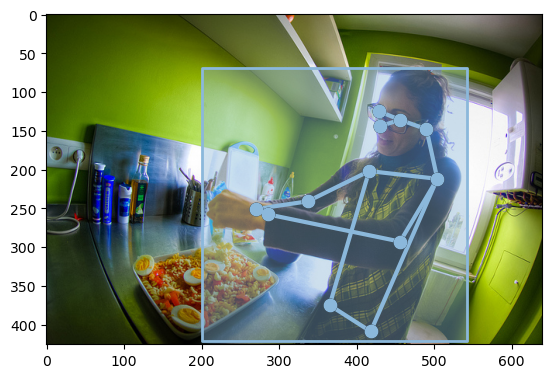

In [18]:
# random.seed(429)
# person_sample = random.sample(sorted(coco.getImgIds(catIds=[1])), 1)[0]
person_sample = 81177  # 14562  # 168215, 26817, 178557, 345100, 115146, 555537, 431555, 245415, 111756
person_sample

# Let's select one image to visualize
img_id = person_sample
annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=[1])
annotation_id = annotation_ids[0]
len(annotation_ids), annotation_ids[0]

loaded_annotations = coco.loadAnns(ids=annotation_ids)
len(loaded_annotations)

# download image 
image_info = coco.loadImgs(img_id)[0]
response = requests.get(image_info['coco_url'])
image = Image.open(BytesIO(response.content))
print(len(loaded_annotations))

original_keypoints = loaded_annotations[0]['keypoints']

print(f"lowerbody present? {is_lowerbody_present(original_keypoints)}")
print(f"upperbody present? {is_upperbody_present(original_keypoints)}")
xmin, ymin, width, height = get_upperbody_bbox(original_keypoints)


# print(f"xmin: {xmin}")
print(f"head present? {is_head_present(original_keypoints)}")
# print(f"leftarm present? {is_leftarm_present(original_keypoints)}")
# print(f"original bbox: {loaded_annotations[0]['bbox']}")
# print(f"head bbox: {[xmin, ymin, width, height]}")


original_annotation = {
    # 'keypoints': [0 for _ in range(57)], 
    'keypoints': original_keypoints, 
    'bbox': loaded_annotations[0]['bbox'],
    'category_id': 1, 
}

print(f"image id: {person_sample}")
plt.imshow(image)
# plt.axis('off')
coco.showAnns([original_annotation], draw_bbox=True)


In [15]:
coco.info()

description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01


In [16]:
# Function to create Pascal-style XML annotations
# def create_head_xml(img_info, annotations, output_annotation_dir, categories):
def create_head_xml(img_id):
    """
    Generates a Pascal VOC-style XML file for a given image and its annotations.

    Args:
    - img_info (dict): Image metadata from COCO.
    - annotations (list): List of annotations for the image.
    - output_annotation_dir (str): Directory to save the XML file.
    - categories (list): List of category names to include in the annotations.
    """

    # we can just get the img info and annotations directly here
    img_info = coco_all_anno.loadImgs(img_id)[0]
    annotation_ids = coco_all_anno.getAnnIds(img_id)

    xml_root = Element('annotation')
    folder = SubElement(xml_root, 'folder')
    folder.text = 'VOC2007'

    filename = SubElement(xml_root, 'filename')
    filename.text = img_info['file_name']

    # default source
    source = SubElement(xml_root, 'source')
    database = SubElement(source, 'database')
    database.text = 'COCO Database'

    image = SubElement(source, 'image')
    image.text = 'flickr'

    annotation_tag = SubElement(source, 'annotation')
    annotation_tag.text = 'PASCAL VOC2007'

    flicker_id = SubElement(source, 'flickerid')
    flicker_id.text = '341012865'

    # default owner
    owner = SubElement(xml_root, 'owner')
    flicker_id = SubElement(owner, 'flickerid')
    flicker_id.text = 'Default owner'
    owner_name = SubElement(owner, 'name')
    owner_name.text = 'Default ownername'

    size = SubElement(xml_root, 'size')
    SubElement(size, 'width').text = str(img_info['width'])
    SubElement(size, 'height').text = str(img_info['height'])
    SubElement(size, 'depth').text = '3'  # Assuming RGB images

    segmented = SubElement(xml_root, 'segmented')
    segmented.text = '0'

    for ann_id in annotation_ids:
        # if person, load from coco, else load from coco_all_anno
        ann = coco_all_anno.loadAnns(ann_id)[0]
        # Include only objects in the specified categories
        cat_id = ann['category_id']
        if cat_id not in id_categories.keys():
            continue

        cat_name = id_categories[cat_id]

        # for parts, 
        # {'head': [[]], 'torso': [[]], 'upperarm': [[], []]}
        # for non person, 
        # {'car': [[]]}
        category_bbox = defaultdict(list)

        # Bounding box (bbox) depends on the parts 
        # the same annotation could be used for different parts 
        if cat_name == 'person':
            ann = coco.loadAnns(ann_id)[0]
            original_bbox = ann['bbox']
            original_keypoints = ann['keypoints']
            # person 
            category_bbox['person'].append(original_bbox)
            # head 
            if is_head_present(original_keypoints):
                bbox = get_head_bbox(original_keypoints)
                category_bbox['head'].append(bbox)
            # upperbody
            if is_upperbody_present(original_keypoints):
                bbox = get_upperbody_bbox(original_keypoints)
                category_bbox['upperbody'].append(bbox)
            # lowerbody
            if is_lowerbody_present(original_keypoints):
                bbox = get_lowerbody_bbox(original_keypoints)
                category_bbox['lowerbody'].append(bbox)
        else:
            bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
            category_bbox[cat_name].append(bbox)

        for final_category, bboxes in category_bbox.items():
            for bbox in bboxes:
                x_min = bbox[0]
                y_min = bbox[1]
                x_max = bbox[0] + bbox[2]
                y_max = bbox[1] + bbox[3]
        
                obj = SubElement(xml_root, 'object')
                name = SubElement(obj, 'name')
                name.text = final_category  # Category name from COCO annotation
        
                # Default difficulty 0
                difficult = SubElement(obj, 'difficult')
                difficult.text = '0'
                
                # Default pose and truncated values
                pose = SubElement(obj, 'pose')
                pose.text = 'Unspecified'
        
                truncated = SubElement(obj, 'truncated')
                is_truncated = (
                    x_min < 0 or y_min < 0 or x_max > img_info['width'] or y_max > img_info['height']
                )
                truncated.text = '1' if is_truncated else '0'
        
                # Bounding box
                bndbox = SubElement(obj, 'bndbox')
                SubElement(bndbox, 'xmin').text = str(max(0, int(x_min)))  # Clip to image boundaries
                SubElement(bndbox, 'ymin').text = str(max(0, int(y_min)))
                SubElement(bndbox, 'xmax').text = str(min(img_info['width'], int(x_max)))
                SubElement(bndbox, 'ymax').text = str(min(img_info['height'], int(y_max)))

    # If no relevant annotations, skip saving the XML
    if not any(cat_name in categories for ann in annotations):
        print(f"Skipping XML generation for {img_info['file_name']} - no relevant annotations.")
        return

    # Pretty format 
    asstring = tostring(xml_root, 'utf-8')
    parsed_xml = parseString(asstring)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")

    # Remove the XML declaration manually
    pretty_xml = '\n'.join(pretty_xml.splitlines()[1:])

    # Save XML
    output_file = os.path.join(annotations_dir, f"{os.path.splitext(img_info['file_name'])[0]}.xml")
    with open(output_file, 'w') as f:
        f.write(pretty_xml)


In [17]:
head_instance_target = 5000
arm_instance_target = 4
num_images_per_category = 200

person_considered = 0
person_with_head = 0
person_with_upperbody = 0
person_with_lowerbody = 0

In [28]:
# To freshly download (erase existing data) 
clear_folder(annotations_dir)
clear_folder(sets_dir)
clear_folder(images_dir)

In [29]:
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

all_images = set()
# Track globally selected image IDs to avoid duplicates
globally_selected_image_ids = set()
random.seed(429)

# Prepare data structures
# train_txt_path = os.path.join(sets_dir, "train.txt")
# category_txt_files = {category: open(os.path.join(sets_dir, f"{category}_train.txt"), "w") for category in categories}
positive_samples = defaultdict(set)
annotations_by_image = {}

# Prepare split-specific data structures
splits = {
    "train": {"image_ids": set(), "annotations": {}, "images": set()},
    "val": {"image_ids": set(), "annotations": {}, "images": set()},
    "test": {"image_ids": set(), "annotations": {}, "images": set()},
    "trainval": {"image_ids": set(), "annotations": {}, "images": set()}
}

# Ensure image directory exists
os.makedirs(images_dir, exist_ok=True)

# Process each category
for category, category_id in tqdm(category_ids.items(), desc="Processing categories"):
    print(f"Processing category: {category}")
    
    # Handle 'person' category separately
    if category == 'person':
        head_counter = 0
        # arm_counter = 0
        selected_image_ids = []
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)

        # Collect images until the instance target is reached
        for img_id in image_ids:
            # print(f"Person count now: {instance_count}")
            if img_id in globally_selected_image_ids:
                continue
                
            # if this image only contains person and head / arm is not present 
            # then skip 
            ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[category_id])
            la = coco.loadAnns(ann_ids)
            # # If we want to only get the images that only have shoulder and above
            # mask = [is_only_head_present(ann) for ann in la]
            # if sum(mask) != len(la):
            #     continue
            
            person_count = len(ann_ids)
            person_considered += person_count
            head_count = sum([is_head_present(ann['keypoints']) for ann in la])
            upperbody_count = sum([is_leftarm_present(ann['keypoints']) for ann in la])
            lowerbody_count = sum([is_rightarm_present(ann['keypoints']) for ann in la])
            if head_count == 0 and upperbody_count == 0 and lowerbody_count == 0:
                continue

            # if head_counter + head_count <= head_instance_target or arm_counter + arm_count <= arm_instance_target:
            if head_counter + head_count <= head_instance_target:
                selected_image_ids.append(img_id)
                globally_selected_image_ids.add(img_id)
                head_counter += head_count
                person_with_head += head_count
                person_with_upperbody += upperbody_count
                person_with_lowerbody += lowerbody_count
            else:
                break
                
        print(f"Selected {len(selected_image_ids)} images to meet {head_counter} 'head' instances and {arm_counter} 'arm' instances.")
        
    else:
        # Default behavior for other categories
        # With the addition that we don't want person in that image also 
        image_ids = coco_all_anno.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)
        selected_image_ids = []
        for img_id in image_ids:
            if img_id in globally_selected_image_ids:
                continue
            categories_in_img = [ann['category_id'] for ann in coco_all_anno.loadAnns(coco_all_anno.getAnnIds(imgIds=[img_id]))]
            if 1 in categories_in_img:
                continue
            selected_image_ids.append(img_id)
            globally_selected_image_ids.add(img_id)
            if len(selected_image_ids) >= num_images_per_category:
                break
    print(f"Selected {len(selected_image_ids)} unique images for category {category}.")

    # Split selected images into train, val, and test
    random.shuffle(selected_image_ids)
    num_images = len(selected_image_ids)
    train_end = int(num_images * train_ratio)
    val_end = train_end + int(num_images * val_ratio)
    print(f"num_immages: {num_images}, train_end: {train_end}, val_end: {val_end}")

    splits["train"]["image_ids"].update(selected_image_ids[:train_end])
    splits["val"]["image_ids"].update(selected_image_ids[train_end:val_end])
    splits["test"]["image_ids"].update(selected_image_ids[val_end:])

    # Collect annotations and positive samples
    for split in ["train", "val", "test"]:
        for img_id in splits[split]["image_ids"]:
            annotations = coco_all_anno.loadAnns(coco_all_anno.getAnnIds(imgIds=[img_id]))
            person_annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            splits[split]["annotations"][img_id] = annotations
            splits[split]["images"].add(
                os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
            )
            # Update positive samples that are non person
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id != 1 and cat_id in id_categories.keys():
                    positive_samples[id_categories[cat_id]].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )
            # Update positive samples that are person
            for ann in person_annotations:
                original_keypoints = ann['keypoints']
                # check for head part
                if ann['category_id'] == 1 and is_head_present(original_keypoints):
                    positive_samples['head'].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )
                # check for arm part
                if ann['category_id'] == 1 and is_upperbody_present(original_keypoints):
                    positive_samples['upperbody'].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )
                # check for lowerbody part
                if ann['category_id'] == 1 and is_lowerbody_present(original_keypoints):
                    positive_samples['lowerbody'].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )

# Create trainval split (combine train and val)
splits["trainval"]["image_ids"] = splits["train"]["image_ids"].union(splits["val"]["image_ids"])
splits["trainval"]["annotations"] = {**splits["train"]["annotations"], **splits["val"]["annotations"]}
splits["trainval"]["images"] = splits["train"]["images"].union(splits["val"]["images"])

# Download images and create XML annotations for each split
for split, data in splits.items():
    for img_id, annotations in tqdm(data["annotations"].items(), desc=f"Processing {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = os.path.splitext(img_info['file_name'])[0]
        img_filepath = os.path.join(images_dir, img_info['file_name'])

        # Download the image if not already downloaded
        if img_filename not in all_images:
            if not os.path.exists(img_filepath):
                try:
                    response = requests.get(img_info['coco_url'], stream=True, timeout=10)
                    response.raise_for_status()
                    with open(img_filepath, 'wb') as f:
                        for chunk in response.iter_content(1024):
                            f.write(chunk)
                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {img_info['file_name']}: {e}")
                    continue  # Skip this image on failure

            all_images.add(img_filename)

        # Generate XML annotation
        # create_pascal_xml(img_info, annotations, annotations_dir, categories)
        # create_head_xml(img_info, annotations, head_annotations_dir, categories)
        create_head_xml(img_id)

# Write ImageSets files for each split
for split, data in splits.items():
    txt_path = os.path.join(sets_dir, f"{split}.txt")
    with open(txt_path, "w") as file:
        for img_filename in sorted(data["images"]):
            file.write(f"{img_filename}\n")

    # Write category-specific files
    for category in categories:
        # if category == 'person':
        #     continue
        category_txt_path = os.path.join(sets_dir, f"{category}_{split}.txt")
        with open(category_txt_path, "w") as category_file:
            for img_filename in sorted(data["images"]):
                label = "1" if img_filename in positive_samples[category] else "-1"
                category_file.write(f"{img_filename} {label}\n")

print(f"ImageSets for train, val, test, and trainval created at {sets_dir}.")


Processing categories:   0%|                             | 0/22 [00:00<?, ?it/s]

Processing category: person
Selected 3436 images to meet 4996 'head' instances and 0 'arm' instances.
Selected 3436 unique images for category person.
num_immages: 3436, train_end: 2405, val_end: 2920


Processing categories:   9%|█▉                   | 2/22 [00:01<00:09,  2.06it/s]

Processing category: bicycle
Selected 200 unique images for category bicycle.
num_immages: 200, train_end: 140, val_end: 170
Processing category: car
Selected 200 unique images for category car.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  18%|███▊                 | 4/22 [00:01<00:05,  3.59it/s]

Processing category: motorcycle
Selected 200 unique images for category motorcycle.
num_immages: 200, train_end: 140, val_end: 170
Processing category: airplane
Selected 200 unique images for category airplane.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  27%|█████▋               | 6/22 [00:01<00:03,  4.65it/s]

Processing category: bus
Selected 200 unique images for category bus.
num_immages: 200, train_end: 140, val_end: 170
Processing category: train
Selected 200 unique images for category train.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  36%|███████▋             | 8/22 [00:02<00:02,  4.73it/s]

Processing category: boat
Selected 200 unique images for category boat.
num_immages: 200, train_end: 140, val_end: 170
Processing category: bird
Selected 200 unique images for category bird.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  45%|█████████           | 10/22 [00:02<00:02,  5.31it/s]

Processing category: cat
Selected 200 unique images for category cat.
num_immages: 200, train_end: 140, val_end: 170
Processing category: dog
Selected 200 unique images for category dog.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  55%|██████████▉         | 12/22 [00:02<00:01,  5.49it/s]

Processing category: horse
Selected 200 unique images for category horse.
num_immages: 200, train_end: 140, val_end: 170
Processing category: sheep
Selected 200 unique images for category sheep.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  64%|████████████▋       | 14/22 [00:03<00:01,  5.59it/s]

Processing category: cow
Selected 200 unique images for category cow.
num_immages: 200, train_end: 140, val_end: 170
Processing category: bottle
Selected 200 unique images for category bottle.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  73%|██████████████▌     | 16/22 [00:03<00:01,  4.73it/s]

Processing category: chair
Selected 200 unique images for category chair.
num_immages: 200, train_end: 140, val_end: 170
Processing category: couch
Selected 200 unique images for category couch.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  77%|███████████████▍    | 17/22 [00:03<00:01,  4.78it/s]

Processing category: potted plant
Selected 200 unique images for category potted plant.
num_immages: 200, train_end: 140, val_end: 170


Processing categories:  86%|█████████████████▎  | 19/22 [00:04<00:00,  4.63it/s]

Processing category: dining table
Selected 200 unique images for category dining table.
num_immages: 200, train_end: 140, val_end: 170
Processing category: head
Selected 0 unique images for category head.
num_immages: 0, train_end: 0, val_end: 0


Processing categories:  95%|███████████████████ | 21/22 [00:04<00:00,  4.99it/s]

Processing category: upperbody
Selected 0 unique images for category upperbody.
num_immages: 0, train_end: 0, val_end: 0
Processing category: lowerbody
Selected 0 unique images for category lowerbody.
num_immages: 0, train_end: 0, val_end: 0


Processing trainval images: 100%|██████████| 5980/5980 [00:06<00:00, 961.55it/s]


ImageSets for train, val, test, and trainval created at /Users/junitasirait/dpmp/VOCdevkit/VOC2007_coco/ImageSets/Main.


In [94]:
print(f"person_considered: {person_considered}")
print(f"person_with_head: {person_with_head}")
print(f"person_with_upperbody: {person_with_upperbody}")
print(f"person_with_lowerbody: {person_with_lowerbody}")

person_considered: 21163
person_with_head: 6001
person_with_upperbody: 5965
person_with_lowerbody: 6103
